# IO: Saving and loading simulations
The `FerriteProblems.jl` package includes support for saving simulation data using
[`JLD2.jl`](https://github.com/JuliaIO/JLD2.jl). This examples shows some examples
of how this can be done. Specifically, we use the data saved during the plasticity
example:

In [1]:
using Ferrite, FerriteProblems
import FerriteProblems as FP
include("plasticity.jl");

In that example, the displacements and state variables were saved in each time step.
In this example, we use the data saved in the folder `B` (using the `AdaptiveTimeStepper`)
and plot a few interesting cases:
* Maximum von Mises stress as function of time
* Export the final displacements and stress to `vtk`

We start by loading the results

In [2]:
io = FerriteIO("B/FerriteIO.jld2")
def = FP.getdef(io)
post = FP.getpost(io);

┌ Warning: type Main.##296.J2PlasticityMaterialState{Float64,Tensors.SymmetricTensor{2, 3, Float64, 6}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/ryhNR/src/data/reconstructing_datatypes.jl:495
┌ Warning: type Main.##296.VectorRamp{3,Float64} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/ryhNR/src/data/reconstructing_datatypes.jl:495
┌ Warning: type Main.##296.J2Plasticity{Float64,Tensors.SymmetricTensor{4, 3, Float64, 36}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/ryhNR/src/data/reconstructing_datatypes.jl:495
┌ Warning: type Main.##296.PlasticityPostProcess{Float64} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/ryhNR/src/data/reconstructing_datatypes.jl:495


Then, we get the time history and the displacement data saved to the `post` struct

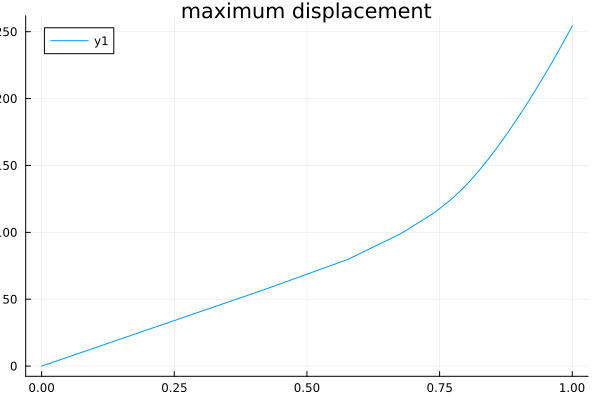

In [3]:
t_history = FP.gettimedata(io)
u_mag = post.umag

plt1 = plot()
plot!(plt1, t_history, u_mag*1e3)
title!(plt1, "maximum displacement")
xlabel!(plt1, "time [s]")
ylabel!(plt1, "umax [mm]")

run `display(plt1)`to see the plot.

The maximum von Mises stress for each step is calculated next. Note that `step` refers
to the count of saved steps, and not the actual simulation steps.

In [4]:
function get_max_vm_stress(io, step)
    states = FP.getipdata(io, step, "state") # ::Dict{Int,Vector{J2PlasticityMaterialState}}
    σ_vm = maximum(cellstates -> maximum(state -> vonMises(state.σ), cellstates), values(states))
    return σ_vm
end

σ_vm = get_max_vm_stress.((io,), 1:length(t_history));

┌ Warning: type Main.##296.J2PlasticityMaterialState{Float64,Tensors.SymmetricTensor{2, 3, Float64, 6}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/ryhNR/src/data/reconstructing_datatypes.jl:495


Plot the analyzed results

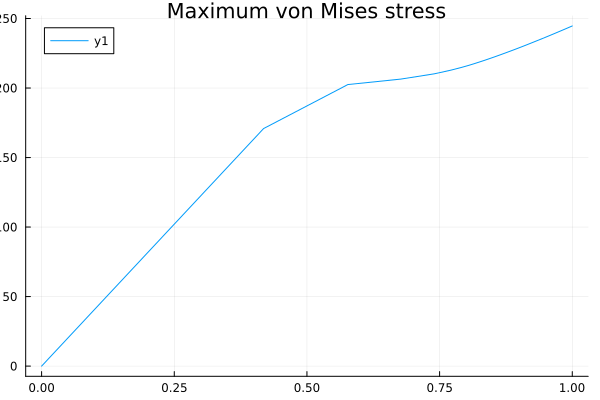

In [5]:
plt2=plot()
plot!(plt2, t_history, σ_vm*1e-6)
title!(plt2, "Maximum von Mises stress")
xlabel!(plt2, "time [s]")
ylabel!(plt2, "stress [MPa]")

run `display(plt2)`to see the plot.

Finally, we extract the degrees of freedom and the stresses in each element
at the last step to save to vtk.

In [6]:
step = length(t_history)
u = FP.getdofdata(io, step)
states = FP.getipdata(io, step, "state")
dh = FP.getdh(def)
mises_values = zeros(getncells(dh.grid))
for (el, cell_states) in pairs(states) # states::Dict{Int}
    for state in cell_states
        mises_values[el] += vonMises(state.σ)
    end
    mises_values[el] /= length(cell_states) # average von Mises stress
end
vtk_grid("plasticity", dh) do vtkfile
    vtk_point_data(vtkfile, dh, u) # displacement field
    vtk_cell_data(vtkfile, mises_values, "von Mises [Pa]")
end;

We do need to close any open files from the `io` object, which we simply do
by calling `close`:

In [7]:
close(io)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*